In [44]:
import findspark
findspark.init()

import pyspark


In [45]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField,StringType,IntegerType,StructType,DateType,FloatType
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.feature import StringIndexer,VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import RandomForestClassifier,DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col,isnan, when, count

In [46]:
spark = SparkSession \
    .builder \
    .appName("Proyecto") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

In [47]:
def EscribirDatosEnTabla(dataframe,NombreTabla):
    dataframe \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", NombreTabla) \
    .save()

def LeerDatosEnBD(NombreTabla):
    return spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", NombreTabla) \
    .load()

Se leen los datos de los accidentes

In [48]:
def leerDatosAccidents():
    return spark \
        .read \
        .format("csv") \
        .option("path", "Datos/US_Accidents_Dec21_updated_solo_2021.csv") \
        .option("header", True) \
        .schema(StructType([
                    StructField("ID", StringType()),
                    StructField("Severity", IntegerType()),
                    StructField("Start_Time", StringType()),
                    StructField("End_Time", StringType()),
                    StructField("Start_Lat", FloatType()),
                    StructField("Start_Lng", FloatType()),
                    StructField("End_Lat", FloatType()),
                    StructField("End_Lng", FloatType()),
                    StructField("Distance(mi)", FloatType()),
                    StructField("Description", StringType()),
                    StructField("Number", IntegerType()),
                    StructField("Street", StringType()),
                    StructField("Side", StringType()),
                    StructField("City", StringType()),
                    StructField("County", StringType()),
                    StructField("State", StringType()),
                    StructField("Zipcode", StringType()),
                    StructField("Country", StringType()),
                    StructField("Timezone", StringType()),
                    StructField("Airport_Code", StringType()),
                    StructField("Weather_Timestamp", StringType()),
                    StructField("Temperature(F)", FloatType()),
                    StructField("Wind_Chill(F)", FloatType()),
                    StructField("Humidity(%)", FloatType()),
                    StructField("Pressure(in)", FloatType()),
                    StructField("Visibility(mi)", FloatType()),
                    StructField("Wind_Direction", StringType()),
                    StructField("Wind_Speed(mph)", FloatType()),
                    StructField("Precipitation(in)", FloatType()),
                    StructField("Weather_Condition", StringType())
                    ])) \
        .load()
accidentsUSAFull=leerDatosAccidents()
print(accidentsUSAFull.count())
#accidentsUSAFull.select(to_timestamp(accidentsUSAFull.Start_Time, 'MM-dd-YYYY HH:mm:ss').alias('dt')).show(1)
#accidentsUSAFull.printSchema()
accidentsUSAFull= accidentsUSAFull.withColumn('col_with_date_format',F.to_date(accidentsUSAFull.Start_Time))

665578


Filtramos un poco el dataframe para solo obtener las columnas de nuestro interes

In [49]:
accidentsUSA=accidentsUSAFull.select(accidentsUSAFull["Severity"],
accidentsUSAFull["Start_Time"],accidentsUSAFull["End_Time"],accidentsUSAFull["City"],
accidentsUSAFull["County"],accidentsUSAFull["State"],accidentsUSAFull["Temperature(F)"],
accidentsUSAFull["Wind_Chill(F)"],
accidentsUSAFull["Humidity(%)"],accidentsUSAFull["Pressure(in)"],accidentsUSAFull["Visibility(mi)"],
accidentsUSAFull["Zipcode"])
accidentsUSA=accidentsUSA.withColumnRenamed('Severity', 'Severity_accident')

Hacemos un describe de los datos

In [50]:
accidentsUSA.describe().show()

+-------+-------------------+----------+---------+----------+---------+------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|summary|  Severity_accident|Start_Time| End_Time|      City|   County| State|   Temperature(F)|     Wind_Chill(F)|       Humidity(%)|      Pressure(in)|   Visibility(mi)|           Zipcode|
+-------+-------------------+----------+---------+----------+---------+------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|  count|             665578|    665578|   665578|    665546|   665578|665578|           652030|            647511|            651439|            653755|           651952|            665402|
|   mean| 2.0362361736716057|      null|     null|      null|     null|  null|66.33849838197395| 65.62951054113367| 63.62939891532438| 29.38612578437885|9.154023118264934| 55796.87925271673|
| stddev|0.26675718167377094|      null|     

Contamos los valores nullos

In [51]:
def ContarNulos(dataframe):
    dataframe.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataframe.columns]
    ).show()

    
ContarNulos(accidentsUSA)
"""Se limpia el dataset"""
def EliminarNulos(DataFrame):
    DataFrame=DataFrame.na.drop()
    return DataFrame

+-----------------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+
|Severity_accident|Start_Time|End_Time|City|County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Zipcode|
+-----------------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+
|                0|         0|       0|  32|     0|    0|         13548|        18067|      14139|       11823|         13626|    176|
+-----------------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+



In [52]:
ContarNulos(accidentsUSA)

+-----------------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+
|Severity_accident|Start_Time|End_Time|City|County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Zipcode|
+-----------------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+
|                0|         0|       0|  32|     0|    0|         13548|        18067|      14139|       11823|         13626|    176|
+-----------------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+



Se limpia el dataset

In [64]:

accidentsUSA=EliminarNulos(accidentsUSA)
accidentsUSA.count()

644494

In [54]:
ContarNulos(accidentsUSA)

+-----------------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+
|Severity_accident|Start_Time|End_Time|City|County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Zipcode|
+-----------------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+
|                0|         0|       0|   0|     0|    0|             0|            0|          0|           0|             0|      0|
+-----------------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+



Se lee el archivo del clima

In [55]:
def leerClima():
    return spark \
        .read \
        .format("csv") \
        .option("path", "Datos/WeatherEvents_Jan2016-Dec2021_solo_2021.csv") \
        .option("header", True) \
        .schema(StructType([
                    StructField("EventId", StringType()),
                    StructField("Type", StringType()),
                    StructField("Severity", StringType()),
                    StructField("StartTime(UTC)", StringType()),
                    StructField("EndTime(UTC)", StringType()),
                    StructField("Precipitation(in)", FloatType()),
                    StructField("TimeZone", StringType()),
                    StructField("AirportCode", StringType()),
                    StructField("LocationLat", FloatType()),
                    StructField("LocationLng", FloatType()),
                    StructField("City", StringType()),
                    StructField("County", StringType()),
                    StructField("State", StringType()),
                    StructField("ZipCode", StringType()),
                
                    ])) \
        .load()
WeatherFull=leerClima()
print(WeatherFull.count())
WeatherFull.show()

168132
+-------+-----+--------+--------------+------------+-----------------+-----------+-----------+-----------+-----------+--------+--------+-----+-------+
|EventId| Type|Severity|StartTime(UTC)|EndTime(UTC)|Precipitation(in)|   TimeZone|AirportCode|LocationLat|LocationLng|    City|  County|State|ZipCode|
+-------+-----+--------+--------------+------------+-----------------+-----------+-----------+-----------+-----------+--------+--------+-----+-------+
| W-1973| Snow|   Light|      1/6/2021|    1/6/2021|              0.0|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
| W-1974| Snow|   Light|     1/10/2021|   1/10/2021|              0.0|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
| W-1975|Storm|  Severe|     1/14/2021|   1/14/2021|              0.0|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
| W-1976|Storm|  Severe|     1/14/2021|   1/14/2021|              0.0|US/Mountain|     

Simplificamos el dataset con lo que necesitamos

In [56]:
weatherUSA=WeatherFull.select(WeatherFull["Type"],
WeatherFull["Severity"],WeatherFull["StartTime(UTC)"],WeatherFull["EndTime(UTC)"],
WeatherFull["Precipitation(in)"],WeatherFull["State"],WeatherFull["County"],
WeatherFull["City"],
WeatherFull["Zipcode"])

In [57]:
weatherUSA.describe().show()

+-------+------+--------+--------------+------------+-------------------+------+-------------+--------+------------------+
|summary|  Type|Severity|StartTime(UTC)|EndTime(UTC)|  Precipitation(in)| State|       County|    City|           Zipcode|
+-------+------+--------+--------------+------------+-------------------+------+-------------+--------+------------------+
|  count|168132|  168132|        168132|      168132|             168132|168132|       168132|  167276|            166132|
|   mean|  null|    null|          null|        null|0.08292591528754716|  null|         null|    null| 52135.55378253437|
| stddev|  null|    null|          null|        null| 0.5147711528937678|  null|         null|    null|26458.947353143405|
|    min|  Cold|   Heavy|      1/1/2021|    1/1/2021|                0.0|    AL|      Alamosa|Abingdon|             10024|
|    max| Storm|     UNK|      9/9/2021|    9/9/2021|             105.58|    WY|Zapata County|  Zapata|             99362|
+-------+------+

In [58]:
ContarNulos(weatherUSA)

+----+--------+--------------+------------+-----------------+-----+------+----+-------+
|Type|Severity|StartTime(UTC)|EndTime(UTC)|Precipitation(in)|State|County|City|Zipcode|
+----+--------+--------------+------------+-----------------+-----+------+----+-------+
|   0|       0|             0|           0|                0|    0|     0| 856|   2000|
+----+--------+--------------+------------+-----------------+-----+------+----+-------+



Se limpia el dataset

In [59]:
weatherUSA=EliminarNulos(weatherUSA)
print(weatherUSA.count())
ContarNulos(weatherUSA)

166132
+----+--------+--------------+------------+-----------------+-----+------+----+-------+
|Type|Severity|StartTime(UTC)|EndTime(UTC)|Precipitation(in)|State|County|City|Zipcode|
+----+--------+--------------+------------+-----------------+-----+------+----+-------+
|   0|       0|             0|           0|                0|    0|     0|   0|      0|
+----+--------+--------------+------------+-----------------+-----+------+----+-------+



In [60]:
weatherUSA.groupBy("Type").count().show()

+-------------+-----+
|         Type|count|
+-------------+-----+
|         Cold| 3232|
|          Fog|45945|
|        Storm| 1430|
|Precipitation| 4306|
|         Hail|   16|
|         Snow|22926|
|         Rain|88277|
+-------------+-----+



Intenamos balancear el target

In [61]:
weatherUSA.groupBy("Type").count().show()

weatherUSA = weatherUSA.withColumn("Type", when(weatherUSA.Type == "Cold","Others") \
      .when(weatherUSA.Type == "Storm","Others") \
      .when(weatherUSA.Type == "Hail","Others") \
        .when(weatherUSA.Type == "Precipitation","Others") \
      .otherwise(weatherUSA.Type))
#weatherUSA.show()

weatherUSA.groupBy("Type").count().show()

n = 8984
weatherUSA = weatherUSA.withColumn('rand_col', F.rand())
weatherUSA = weatherUSA.withColumn("row_num",F.row_number().over(Window.partitionBy("Type")\
                .orderBy("rand_col"))).filter(col("row_num")<=n)\
                .drop("rand_col", "row_num")

weatherUSA.groupBy("Type").count().show()

+-------------+-----+
|         Type|count|
+-------------+-----+
|         Cold| 3232|
|          Fog|45945|
|        Storm| 1430|
|Precipitation| 4306|
|         Hail|   16|
|         Snow|22926|
|         Rain|88277|
+-------------+-----+

+------+-----+
|  Type|count|
+------+-----+
|   Fog|45945|
|Others| 8984|
|  Snow|22926|
|  Rain|88277|
+------+-----+

+------+-----+
|  Type|count|
+------+-----+
|   Fog| 8984|
|Others| 8984|
|  Rain| 8984|
|  Snow| 8984|
+------+-----+



EDA

<AxesSubplot:>

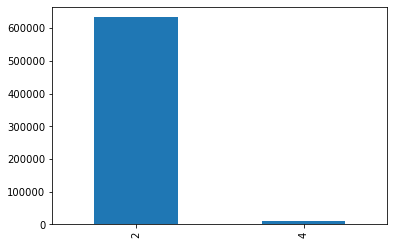

In [62]:
x=accidentsUSA.toPandas()["Severity_accident"].values.tolist()

pd.Series(x).value_counts(sort=False).plot(kind='bar')



In [63]:

y=accidentsUSA.toPandas()["Visibility(mi)"].values.tolist()
x = np.arange(0, len(y))
print(len(y))
plt.title("Visibilidad en millas")

plt.plot(x, y, color ="green")
plt.show()

KeyboardInterrupt: 

<AxesSubplot:>

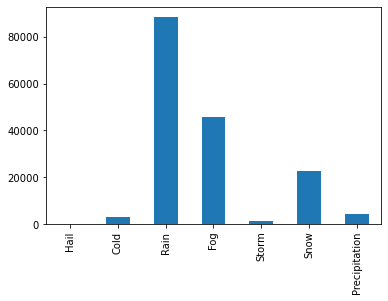

In [ ]:
x=weatherUSA.toPandas()["Type"].values.tolist()

pd.Series(x).value_counts(sort=False).plot(kind='bar')

<AxesSubplot:>

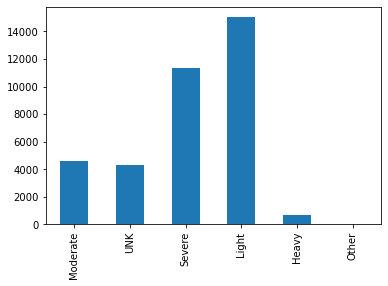

In [ ]:
x=weatherUSA.toPandas()["Severity"].values.tolist()

pd.Series(x).value_counts(sort=False).plot(kind='bar')

Union de dataframes


In [ ]:
FullJoinDF=weatherUSA.join(accidentsUSA, (weatherUSA["City"] == accidentsUSA["City"]) &
   ( weatherUSA["County"] == accidentsUSA["County"])  &
   ( weatherUSA["State"] == accidentsUSA["State"])  &
   ( weatherUSA["ZipCode"] == accidentsUSA["ZipCode"])  &
   ( weatherUSA["StartTime(UTC)"] == accidentsUSA["Start_Time"]),"inner")

rows=FullJoinDF.count()
print(rows)

FullJoinDF.printSchema()

FullJoinDF.groupBy("Type").count().show()

2384
root
 |-- Type: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- StartTime(UTC): string (nullable = true)
 |-- EndTime(UTC): string (nullable = true)
 |-- Precipitation(in): float (nullable = true)
 |-- State: string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Severity_accident: integer (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Temperature(F): float (nullable = true)
 |-- Wind_Chill(F): float (nullable = true)
 |-- Humidity(%): float (nullable = true)
 |-- Pressure(in): float (nullable = true)
 |-- Visibility(mi): float (nullable = true)
 |-- Zipcode: string (nullable = true)

+------+-----+
|  Type|count|
+------+-----+
|   Fog|  412|
|Others|  505|
|  Rain|  444|
|  Snow| 1023|
+------+-----+



Se codifica el target

In [ ]:
indexer = StringIndexer(inputCol="Type", outputCol="TypeIndex") 
indexed = indexer.fit(FullJoinDF).transform(FullJoinDF) 
FullJoinDF=indexed
indexers = StringIndexer(inputCol="Severity_accident", outputCol="Severity_accidentIndex") 
indexeds = indexers.fit(FullJoinDF).transform(FullJoinDF) 

#indexeds.select("Type","TypeIndex").show()
FullJoinDF=indexeds

FullJoinDF.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- StartTime(UTC): string (nullable = true)
 |-- EndTime(UTC): string (nullable = true)
 |-- Precipitation(in): float (nullable = true)
 |-- State: string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Severity_accident: integer (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Temperature(F): float (nullable = true)
 |-- Wind_Chill(F): float (nullable = true)
 |-- Humidity(%): float (nullable = true)
 |-- Pressure(in): float (nullable = true)
 |-- Visibility(mi): float (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- TypeIndex: double (nullable = false)
 |-- Severity_accidentIndex: double (nullable = false)



Se escogen solo los valores que tienen 

In [ ]:
FullJoinDF=FullJoinDF.select("TypeIndex","Precipitation(in)","Temperature(F)","Wind_Chill(F)","Humidity(%)","Pressure(in)","Visibility(mi)","Severity_accidentIndex")
FullJoinDF.show()


+---------+-----------------+--------------+-------------+-----------+------------+--------------+----------------------+
|TypeIndex|Precipitation(in)|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Severity_accidentIndex|
+---------+-----------------+--------------+-------------+-----------+------------+--------------+----------------------+
|      1.0|              0.0|          23.0|          7.0|       50.0|       28.02|          10.0|                   0.0|
|      1.0|              0.0|          23.0|          7.0|       50.0|       28.02|          10.0|                   0.0|
|      1.0|              0.0|          23.0|          7.0|       50.0|       28.02|          10.0|                   0.0|
|      1.0|              0.0|          23.0|          7.0|       50.0|       28.02|          10.0|                   0.0|
|      1.0|              0.0|          23.0|          7.0|       50.0|       28.02|          10.0|                   0.0|
|      1.0|             

Se escribe en la BD

In [ ]:
EscribirDatosEnTabla(FullJoinDF,"datos")

Se vectoriza y escalan los datos

In [ ]:
def  vectorizar(dataframe):
    assembler = VectorAssembler(
                    inputCols=[
                "Precipitation(in)","Temperature(F)","Wind_Chill(F)","Humidity(%)","Pressure(in)","Visibility(mi)","Severity_accidentIndex"],
                    outputCol='features')

    vector_df = assembler.transform(dataframe)
    vector_df = vector_df.select(['features', 'TypeIndex'])
    return vector_df


def Escalador(dataframe):
    standard_scaler = StandardScaler(inputCol='features', outputCol='scaled')
    scale_model = standard_scaler.fit(dataframe)

    scaled_df = scale_model.transform(dataframe)
   
    return scaled_df


data=LeerDatosEnBD("datos")
data.show()


+---------+-----------------+--------------+-------------+-----------+------------+--------------+----------------------+
|TypeIndex|Precipitation(in)|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Severity_accidentIndex|
+---------+-----------------+--------------+-------------+-----------+------------+--------------+----------------------+
|      0.0|              0.0|          28.0|         28.0|       93.0|       24.58|           4.0|                   0.0|
|      0.0|             0.08|          28.0|         28.0|       93.0|       24.58|           4.0|                   0.0|
|      0.0|              0.0|          28.0|         28.0|       93.0|       24.58|           4.0|                   0.0|
|      0.0|             0.02|          28.0|         28.0|       93.0|       24.58|           4.0|                   0.0|
|      0.0|              0.0|          28.0|         28.0|       93.0|       24.58|           4.0|                   0.0|
|      0.0|             

Separacion de datos

In [ ]:
"""Separacion de datos"""
train, test = data.randomSplit([0.7, 0.3], seed = 2)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
train.printSchema()

train.printSchema()
train=vectorizar(train)

train=Escalador(train)

testData=vectorizar(test)
testData=Escalador(testData)

Training Dataset Count: 1652
Test Dataset Count: 732
root
 |-- TypeIndex: double (nullable = true)
 |-- Precipitation(in): float (nullable = true)
 |-- Temperature(F): float (nullable = true)
 |-- Wind_Chill(F): float (nullable = true)
 |-- Humidity(%): float (nullable = true)
 |-- Pressure(in): float (nullable = true)
 |-- Visibility(mi): float (nullable = true)
 |-- Severity_accidentIndex: double (nullable = true)

root
 |-- TypeIndex: double (nullable = true)
 |-- Precipitation(in): float (nullable = true)
 |-- Temperature(F): float (nullable = true)
 |-- Wind_Chill(F): float (nullable = true)
 |-- Humidity(%): float (nullable = true)
 |-- Pressure(in): float (nullable = true)
 |-- Visibility(mi): float (nullable = true)
 |-- Severity_accidentIndex: double (nullable = true)



Random Forest

In [ ]:
rf = RandomForestClassifier(featuresCol = 'scaled', labelCol = 'TypeIndex')
evaluator = MulticlassClassificationEvaluator(
    labelCol="TypeIndex", predictionCol="prediction", metricName="accuracy")
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 5, 10])
               .addGrid(rf.maxBins, [5, 10, 20])
               .addGrid(rf.numTrees, [5, 20, 50])
             .build())

rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = evaluator,
                      numFolds = 4)

rfModel = rfcv.fit(train)

predictions = rfModel.transform(testData)
accuracy = evaluator.evaluate(predictions)




predictions.printSchema()
predictions=predictions.withColumnRenamed("prediction","Prediccion")
predictions.select("TypeIndex", "Prediccion").show(30)
predictions=predictions.select("Prediccion")
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

predictions_train = rfModel.transform(train)
accuracy = evaluator.evaluate(predictions_train)




predictions_train.printSchema()
predictions_train=predictions_train.withColumnRenamed("prediction","Prediccion")
predictions_train.select("TypeIndex", "Prediccion").show(30)
predictions_train=predictions_train.select("Prediccion")
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

root
 |-- features: vector (nullable = true)
 |-- TypeIndex: double (nullable = true)
 |-- scaled: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

+---------+----------+
|TypeIndex|Prediccion|
+---------+----------+
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       3.0|
|      0.0|       3.0|
|      0.0|       0.0|
|      0.0|       3.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0

Analisis Random Forest 
Podemos obsservar que tiene un desempeño un poco malo llegando casi al 80% con el test set, utilizando cross-validation. Tambien podemos observar que con el train set tiene un accuracy de 91%, como la diferencia no es tan grande podemos decir que hay un poco de overfitting

Decision Tree

In [ ]:
dt = DecisionTreeClassifier(featuresCol = 'scaled', labelCol = 'TypeIndex',  maxDepth=15)
dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(dt.maxBins, [10, 20, 40, 80, 100])
             .build())
evaluator = MulticlassClassificationEvaluator(
    labelCol="TypeIndex", predictionCol="prediction", metricName="accuracy")

dtcv = CrossValidator(estimator = dt,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = evaluator,
                      numFolds = 5)   
dtcvModel = dtcv.fit(train)
print(dtcvModel)

predictions = dtcvModel.transform(testData)




accuracy = evaluator.evaluate(predictions)
predictions.printSchema()
predictions=predictions.withColumnRenamed("prediction","Prediccion")
predictions.select("TypeIndex", "Prediccion").show(30)
predictions=predictions.select("Prediccion")
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))


predictions_train = dtcvModel.transform(train)




accuracy = evaluator.evaluate(predictions_train)
predictions_train.printSchema()
predictions_train=predictions_train.withColumnRenamed("prediction","Prediccion")
predictions_train.select("TypeIndex", "Prediccion").show(30)
predictions_train=predictions_train.select("Prediccion")
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

CrossValidatorModel_363b2f579cbe
root
 |-- features: vector (nullable = true)
 |-- TypeIndex: double (nullable = true)
 |-- scaled: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

+---------+----------+
|TypeIndex|Prediccion|
+---------+----------+
|      0.0|       0.0|
|      0.0|       3.0|
|      0.0|       3.0|
|      0.0|       3.0|
|      0.0|       0.0|
|      0.0|       3.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       1.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       1.0|
|      0.0|       1.0|
|      0.0|       1.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0

Analisis Decision Tree
Podemos obsservar que tiene un desempeño un poco pobre utilizando cross-validation. Tambien podemos observar que con el train set tiene un accuracy de 97%, claro indicador de que hay overfitting